## Predicting Total C% by machine learning using remote sensing and other environmental covariates

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import geopandas as gp
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import rasterio as rio
import earthpy.plot as ep
from rasterio.merge import merge
import earthpy.spatial as es
from osgeo import gdal, gdal_array
import warnings
warnings.filterwarnings("ignore")

### Load data - Year 2012 - Baseline period

In [164]:
landsat_2012 = pd.read_csv("data_with_RS/data_RS_by_month/files_2012_with_RS_2012.csv", sep = ';')
landsat_2012.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Experiment           263 non-null    object 
 1   SP_ID                263 non-null    int64  
 2   sample_distance (m)  263 non-null    int64  
 3   Field                263 non-null    object 
 4   code_field           263 non-null    int64  
 5   Soil_Serie           263 non-null    object 
 6   Soil_symbol          263 non-null    object 
 7   Soil_Code            263 non-null    int64  
 8   Sample_date          263 non-null    object 
 9   Month-year           263 non-null    object 
 10  Year                 263 non-null    int64  
 11  Sample_time          263 non-null    object 
 12  Easting              263 non-null    int64  
 13  Northing             263 non-null    int64  
 14  X                    263 non-null    float64
 15  Y                    263 non-null    flo

In [182]:
# Convert Field,, Year and Soil to dummies and save the file
dat_dummies = pd.get_dummies(landsat_2012, columns = ['Soil_symbol', 'Field'])
#dat_dummies.to_csv('new_files/dat_with_dummies_sentinel.csv', index = False)
dat_dummies.columns

Index(['Experiment', 'SP_ID', 'sample_distance (m)', 'code_field',
       'Soil_Serie', 'Soil_Code', 'Sample_date', 'Month-year', 'Year',
       'Sample_time', 'Easting', 'Northing', 'X', 'Y', 'pH', 'BD_gcm3',
       'OM_%w/w', 'N_total_%w/w', 'C_total_%w/w', 'C_stock_kgm2',
       'conductivity_uScm', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI',
       'GNDVI', 'NDMI', 'EVI', 'BSI', 'Soil_symbol_Dg_Chb', 'Soil_symbol_Fa',
       'Soil_symbol_Hk', 'Soil_symbol_Hw',
       'Field_Bottom Burrows - Bottom Burrows', 'Field_Burrows- Burrows',
       'Field_Dairy Corner', 'Field_Dairy East', 'Field_Dairy North',
       'Field_Dairy South', 'Field_Golden Rove', 'Field_Great Field',
       'Field_Higher Wyke Moor', 'Field_Little Pecketsford',
       'Field_Longlands East', 'Field_Longlands North',
       'Field_Longlands South', 'Field_Lower Wheaty', 'Field_Lower Wyke Moor',
       'Field_Middle Wyke Moor', 'Field_Orchard Dean- Orchard Dean North',
       'Field_Orchard Dean- Orchard Dean South

In [166]:
dat_dummies.drop(['Experiment', 'SP_ID', 'sample_distance (m)', 'Field', 'code_field',
       'Soil_Serie', 'Soil_Code', 'Sample_date', 'Month-year', 'Year',
       'Sample_time', 'Easting', 'Northing', 'X', 'Y'], axis = 1).corr()

,pH,BD_gcm3,OM_%w/w,N_total_%w/w,C_total_%w/w,C_stock_kgm2,conductivity_uScm,B2,B3,B4,...,B7,NDVI,GNDVI,NDMI,EVI,BSI,Soil_symbol_Dg_Chb,Soil_symbol_Fa,Soil_symbol_Hk,Soil_symbol_Hw
pH,1.000000,0.326471,-0.138244,-0.140108,-0.161506,-0.020401,NaN,-0.018258,0.045951,0.024411,...,-0.082894,0.048895,0.037824,0.100856,0.002092,-0.085359,-0.136182,-0.047421,0.085262,0.030645
BD_gcm3,0.326471,1.000000,-0.086369,-0.027671,-0.106978,0.325215,NaN,-0.002344,0.099540,0.030658,...,-0.122577,0.059063,0.047979,0.155576,0.025829,-0.139101,-0.065387,0.106191,0.087980,-0.066874
OM_%w/w,-0.138244,-0.086369,1.000000,0.776884,0.770612,0.703528,NaN,-0.013183,-0.018486,-0.035801,...,-0.012247,-0.065769,-0.064675,-0.059711,-0.036624,0.055944,-0.097672,-0.005365,-0.099855,0.160118
N_total_%w/w,-0.140108,-0.027671,0.776884,1.000000,0.921142,0.864925,NaN,-0.105672,-0.131411,-0.132041,...,-0.135672,-0.085306,-0.086791,-0.042214,-0.021351,0.038938,-0.167608,0.031533,0.005287,0.101549
C_total_%w/w,-0.161506,-0.106978,0.770612,0.921142,1.000000,0.899900,NaN,-0.004862,-0.044371,-0.029168,...,-0.035139,-0.114011,-0.118542,-0.105916,-0.079919,0.105945,-0.129206,0.030595,-0.033186,0.110355
C_stock_kgm2,-0.020401,0.325215,0.703528,0.864925,0.899900,1.000000,NaN,-0.004190,0.005736,-0.013480,...,-0.073825,-0.077767,-0.085983,-0.034079,-0.061390,0.038957,-0.146009,0.079017,-0.013881,0.089837
conductivity_uScm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B2,-0.018258,-0.002344,-0.013183,-0.105672,-0.004862,-0.004190,NaN,1.000000,0.830321,0.893101,...,0.676480,-0.057321,-0.052619,-0.230747,-0.271688,0.241061,0.090840,0.009607,-0.263538,0.174522
B3,0.045951,0.099540,-0.018486,-0.131411,-0.044371,0.005736,NaN,0.830321,1.000000,0.867791,...,0.562185,0.160792,0.136204,0.080424,-0.166447,-0.046947,0.042756,-0.055069,-0.318170,0.276959
B4,0.024411,0.030658,-0.035801,-0.132041,-0.029168,-0.013480,NaN,0.893101,0.867791,1.000000,...,0.516390,-0.259469,-0.258800,-0.312797,-0.553900,0.365748,-0.005187,0.017885,-0.248532,0.224724


In [195]:
# Split the dataset into training and validation
x = dat_dummies[['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'NDVI',
       'GNDVI', 'NDMI', 'EVI', 'BSI', 'Soil_symbol_Dg_Chb', 'Soil_symbol_Fa', 'Soil_symbol_Hk',
       'Soil_symbol_Hw', 'Field_Bottom Burrows - Bottom Burrows', 'Field_Burrows- Burrows',
       'Field_Dairy Corner', 'Field_Dairy East', 'Field_Dairy North',
       'Field_Dairy South', 'Field_Golden Rove', 'Field_Great Field',
       'Field_Higher Wyke Moor', 'Field_Little Pecketsford',
       'Field_Longlands East', 'Field_Longlands North',
       'Field_Longlands South', 'Field_Lower Wheaty', 'Field_Lower Wyke Moor',
       'Field_Middle Wyke Moor', 'Field_Orchard Dean- Orchard Dean North',
       'Field_Orchard Dean- Orchard Dean South', 'Field_Pecketsford',
       'Field_Poor Field', 'Field_Top Burrows', 'Field_Ware Park']]
y = dat_dummies['C_stock_kgm2']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [196]:
# Baseline errors, and display average baseline error
baseline_errors = abs(y_test.mean() - y_test)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  0.73


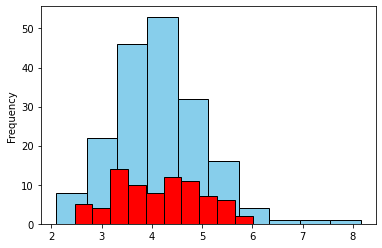

In [197]:
# Plot train and test datasets
y_train.plot(kind='hist', ec = 'black', color = 'skyblue')
y_test.plot(kind='hist', ec = 'black', color ='red')
plt.show()

### Run the models

In [198]:
m1 = GradientBoostingRegressor()
model1 = m1.fit(x_train, y_train)
print('The R2 of the train is {}'.format(round(model1.score(x_train, y_train), 2)))
print('The R2 of the test is {}'.format(round(model1.score(x_test, y_test), 2)))

The R2 of the train is 0.86
The R2 of the test is 0.46


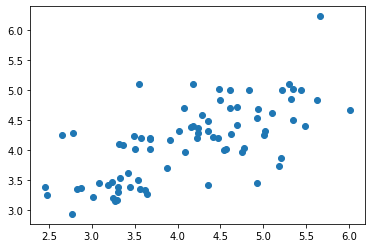

In [199]:
# Predict using Gradient boosting
y_pred = model1.predict(x_test)
plt.scatter(y_test, y_pred)
plt.show()

In [200]:
# Print performance metrics
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred), 2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred), 2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 2))

Mean Absolute Error: 0.48
Mean Squared Error: 0.39
Root Mean Squared Error: 0.63


In [134]:
# Get numerical feature importances
importances = list(model1.feature_importances_)
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(x_train.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:40} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: B3                                       Importance: 0.165
Variable: B4                                       Importance: 0.141
Variable: B2                                       Importance: 0.134
Variable: B6                                       Importance: 0.125
Variable: NDVI                                     Importance: 0.092
Variable: BSI                                      Importance: 0.075
Variable: GNDVI                                    Importance: 0.067
Variable: EVI                                      Importance: 0.066
Variable: B5                                       Importance: 0.048
Variable: B7                                       Importance: 0.045
Variable: NDMI                                     Importance: 0.029
Variable: Soil_symbol_Dg_Chb                       Importance: 0.011
Variable: Soil_symbol_Fa                           Importance: 0.003
Variable: Soil_symbol_Hk                           Importance: 0.0
Variable: Soil_symbol_Hw            

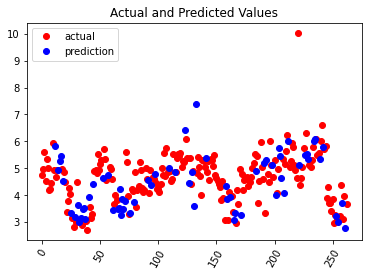

In [88]:
plt.plot(y_train, 'ro', label = 'actual', color = 'red')
plt.plot(y_test, 'ro', label = 'prediction', color = 'blue')
plt.xticks(rotation = '60'); 
plt.legend()
plt.title('Actual and Predicted Values');

## Predict onto raster

In [202]:
## Load raster
with rio.open('C:/Users/neliq/Documents/NIF/Rothamsted/rasters/preditoras/2012/covs_img_soil_field.tif') as covs:
    covs_array = covs.read()
    covs_meta = covs.profile
    covs_affine = covs.profile.pop('transform')
covs_array.shape

(37, 100, 119)

In [203]:
## load image data
img_RS = 'C:/Users/neliq/Documents/NIF/Rothamsted/rasters/preditoras/2012/covs_img_soil_field.tif'

image = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((image.RasterYSize, image.RasterXSize, image.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(image.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = image.GetRasterBand(b + 1).ReadAsArray()
    

## Set the number of columns, rows and bands
rows = image.RasterYSize
cols = image.RasterXSize
bands = image.RasterCount

print('Image extent: {} x {} (row x col)'.format(rows, cols))
print('Number of Bands: {}'.format(bands))

Image extent: 100 x 119 (row x col)
Number of Bands: 37


In [204]:
## Reshape to (row*col, bands)
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :np.int(img.shape[2])].reshape(new_shape)
img_as_array.shape

(11900, 37)

In [206]:
## Predicting into the entire raster
soc_prediction = model1.predict(img_as_array)
soc_prediction = soc_prediction.reshape(img[:, :, 0].shape)
soc_prediction.shape

(100, 119)

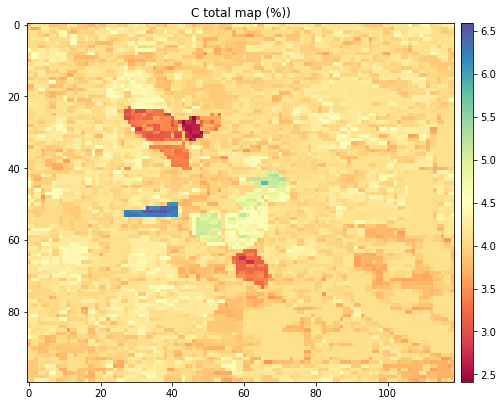

In [207]:
## Plotting the predicted map
fig, axs = plt.subplots(figsize=(8,8))
img = axs.imshow(soc_prediction, cmap = 'Spectral')
plt.title("C total map (%))")
cbar = ep.colorbar(img)
plt.show()

In [208]:
# Export raster
soc_new = soc_prediction.reshape(1, 100,119)
with rio.open('C:/Users/neliq/Documents/NIF/Rothamsted/rasters/maps/2012/CStockL8_2012.tif', 'w', 
              driver = 'GTiff', 
              height = soc_prediction.shape[1], 
              width = soc_prediction.shape[0],
              count = 1,
              dtype = soc_prediction.dtype,
              transform = covs_affine) as dst:
    dst.write(soc_new)

In [ ]:
## End